In [28]:
import numpy as np
import pandas as pd
from scipy import linalg, stats, signal
import mne
import matplotlib.pyplot as plt
import seaborn as sb
from data_util import (
    load_subjects,
    load_subject_data,
    load_data,
    euclidean_alignment,
    label_alignment,
    np_standardize,
)
from copy import deepcopy

In [29]:
data_dir = "../data/vin/Official"

In [88]:
%%time
# fmt: off
# subjects = [
#     # 'K299', 'K300', 
#     'K309', 'K310', 'K311', 'K312', 'K313', 
#     'K314', 'K315', 'K316', 'K318', 'K319', 
#     'K320', 'K321', 'K322', 'K323', 'K324', 
#     'K325', 'K326', 'K327', 'K328', 'K329', 
#     'K330', 'K331', 'K332', 'K333', 'K334', 
#     'K335', 'K336', 'K337', 'K338', 'K339', 
#     'K340', 'K342', 'K343', 'K344', 'K350', 
#     'K351', 'K352', 'K353', 'K354', 'K355', 
#     'K356', 'K357', 'K358', 'K359', 'K360', 
#     'K361', 'K362', 'K363', 'K364', 'K365', 
#     'K366', 'K367', 'K368', 'K369', 'K370', 
#     'K371', 'K372', 'K373', 'K374', 'K375',
# ]

subjects = [
    'K300', 'K309', 'K311', 
    'K312', 'K313', 
    # 'K314', 'K315', 'K316', 'K320', 'K321', 
    # 'K322', 'K323', 'K324', 'K325', 'K327', 
    # 'K328', 'K329', 'K332', 'K335', 'K336', 
    # 'K337', 'K338', 'K339', 'K354', 'K355', 
    # 'K358', 'K359', 'K360', 'K361', 'K362', 
    # 'K364', 'K366', 'K368', 'K369', 'K370', 
    # 'K371', 'K372', 'K373', 'K374', 'K375',
    # "K314", "K324",
]

# use_k_subjects = True  # @param {"type": "boolean"}
# use_bn_subjects = False  # @param {"type": "boolean"}

# subjects = list()
# if use_k_subjects:
#     subjects.extend([subject for subject in full_scenarios_subjects if subject.startswith("K")])
# if use_bn_subjects:
#     subjects.extend([subject for subject in full_scenarios_subjects if subject.startswith("BN")])

subjects = sorted(subjects)

scenarios = [
    "nâng tay trái",
    "nâng tay phải",
    "nâng chân trái",
    "nâng chân phải",
    # "gật đầu",
    # "lắc đầu",
    # "há miệng",
]

events = [
    "Thinking",
    # "Thinking and Acting",
    # "Resting",
    # "Typing",
]

# channels = [
#     "Fp1", "Fp2",
#     "F7", "F3", "Fz", "F4", "F8",
#     "FT9", "FC5", "FC1", "FC2", "FC6", "FT10",
#     "T7", "C3", "Cz", "C4", "T8",
#     "CP5", "CP1", "CP2", "CP6",
#     "P7", "P3", "Pz", "P4", "P8",
#     "PO9", "O1", "Oz", "O2", "PO10",
# ]
channels = [
    # "F3", "Fz", "F4",
    "FC5", "FC1", "FC2", "FC6",
    "C3", "Cz", "C4",
    "CP5", "CP1", "CP2", "CP6",
    # "P3", "Pz", "P4",
]

label_mapping={
    # "nâng tay trái_Thinking": "mi",
    # "nâng tay phải_Thinking": "mi",
    "nâng tay trái_Thinking": "nâng tay trái",
    "nâng tay phải_Thinking": "nâng tay phải",
#     "nâng tay trái_Thinking": "nâng tay",
#     "nâng tay phải_Thinking": "nâng tay",
    # "nâng chân trái_Thinking": "mi",
    # "nâng chân phải_Thinking": "mi",
    "nâng chân trái_Thinking": "nâng chân trái",
    "nâng chân phải_Thinking": "nâng chân phải",
    # "nâng chân trái_Thinking": "nâng chân",
    # "nâng chân phải_Thinking": "nâng chân",
    # "gật đầu_Thinking": "mi",
    # "lắc đầu_Thinking": "mi",
    "gật đầu_Thinking": "gật đầu",
    "lắc đầu_Thinking": "lắc đầu",
    # "gật đầu_Thinking": "đầu",
    # "lắc đầu_Thinking": "đầu",
    "nâng tay trái_Thinking and Acting": "nâng tay trái",
    "nâng tay phải_Thinking and Acting": "nâng tay phải",
    "nâng chân trái_Thinking and Acting": "nâng chân trái",
    "nâng chân phải_Thinking and Acting": "nâng chân phải",
    # "gật đầu_Thinking and Acting": "other",
    # "lắc đầu_Thinking and Acting": "other",
    "Resting": "rest",
}

n_channels = len(channels)

print(f"using {n_channels} channels")

minimal_trial_duration = 4  # @param
window_duration = 2  # @param
window_stride_duration = 0.25  # @param

fmin = 8.0  # @param
fmax = 30.0  # @param

# subjects.remove("K324")

ds = load_data(
    data_dir,  
    subjects=subjects,
    scenarios=scenarios,
    events=events,
    channels=channels,
    label_mapping=label_mapping,
    minimal_trial_duration=minimal_trial_duration,
    window_duration=window_duration, 
    window_stride_duration=window_stride_duration, 
    start_offset=0,
    stop_offset=0,
    fmin=fmin, 
    fmax=fmax, 
    moving_standardize=False,
    epoch_standardize=False,
    resample=None,
    return_raw=False,
    return_preprocessed=False,
    preload=True,
)

# als_subjects = ["ALS01_t1", "ALS01_t2", "ALS02_t1", "ALS02_t2"]

# als_ds = load_data(
#     als_data_dir,  
#     subjects=als_subjects,
#     scenarios=scenarios,
#     events=events,
#     channels=channels,
#     label_mapping=label_mapping,
#     minimal_trial_duration=minimal_trial_duration,
#     window_duration=window_duration, 
#     window_stride_duration=window_stride_duration, 
#     start_offset=0,
#     stop_offset=0,
#     fmin=fmin, 
#     fmax=fmax, 
#     moving_standardize=False,
#     epoch_standardize=False,
#     resample=None,
#     return_raw=False,
#     return_preprocessed=False,
#     preload=True,
# )

# fmt: on

# ds = BaseConcatDataset([ds, als_ds])

for _ds in ds.datasets:
    _ds_info = _ds.description
    if _ds_info["subject"] == "K314":
        _ds_info["subject"] = "K314_t1"
    elif _ds_info["subject"] == "K324":
        _ds_info["subject"] = "K314_t2"

ds_info = ds.description

using 11 channels


trial: 100%|██████████| 61/61 [00:00<00:00, 209.50it/s]


CPU times: user 1.88 s, sys: 173 ms, total: 2.05 s
Wall time: 2.03 s


In [46]:
from sklearn.preprocessing import LabelEncoder

In [89]:
x = list()
y = list()
s = list()
for _ds in ds.datasets:
    x.append(_ds.windows.get_data())
    y.append(np.array(_ds.y, dtype=int))
    s.extend([_ds.description["subject"]] * len(_ds.y))
    
x = np.concatenate(x, axis=0)
y = np.concatenate(y, axis=0)
le = LabelEncoder()
s = le.fit_transform(s)

print(le.classes_)
x.shape, y.shape, s.shape

['K300' 'K309' 'K311' 'K312' 'K313']


((1345, 11, 256), (1345,), (1345,))

In [95]:
x = list()
y = list()
s = list()
for _ds in aligned_ds.datasets:
    x.append(_ds.windows.get_data())
    y.append(np.array(_ds.y, dtype=int))
    s.extend([_ds.description["subject"]] * len(_ds.y))
    
x = np.concatenate(x, axis=0)
y = np.concatenate(y, axis=0)
le = LabelEncoder()
s = le.fit_transform(s)

print(le.classes_)
x.shape, y.shape, s.shape

['K300' 'K309' 'K311' 'K312' 'K313']


((1345, 11, 256), (1345,), (1345,))

In [96]:
c = np.stack([np.cov(xi, rowvar=True) for xi in x])
c.shape

(1345, 11, 11)

In [34]:
from sklearn.manifold import TSNE
from pyriemann.tangentspace import TangentSpace

In [97]:
ts = TangentSpace(metric="riemann")

feat = ts.fit_transform(c)

feat2d = TSNE(n_components=2).fit_transform(feat)

/home/administrator/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/administrator/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [98]:
colors = 'bgrcmyk'
labels = {v: k for k, v in ds.datasets[0].windows.event_id.items()}

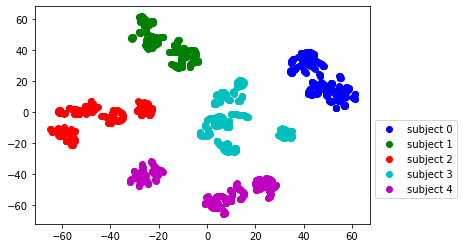

In [93]:
lbl = []
for i, yi in enumerate(np.unique(s)):
    idx = np.where((s == yi))[0]
    plt.scatter(feat2d[idx, 0], feat2d[idx, 1], c=colors[i], marker='o', label=f"subject {i}")
    
#     idx = np.where((y == yi) & (s == 1))[0]
#     plt.scatter(feat2d[idx, 0], feat2d[idx, 1], c=colors[i], marker='+', label=labels[yi])
    
#     idx = np.where((y == yi) & (s == 2))[0]
#     plt.scatter(feat2d[idx, 0], feat2d[idx, 1], c=colors[i], marker='*', label=labels[yi])
    
plt.legend(bbox_to_anchor=(1, 0.5))

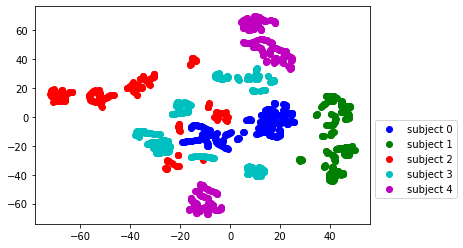

In [99]:
lbl = []
for i, yi in enumerate(np.unique(s)):
    idx = np.where((s == yi))[0]
    plt.scatter(feat2d[idx, 0], feat2d[idx, 1], c=colors[i], marker='o', label=f"subject {i}")
    
#     idx = np.where((y == yi) & (s == 1))[0]
#     plt.scatter(feat2d[idx, 0], feat2d[idx, 1], c=colors[i], marker='+', label=labels[yi])
    
#     idx = np.where((y == yi) & (s == 2))[0]
#     plt.scatter(feat2d[idx, 0], feat2d[idx, 1], c=colors[i], marker='*', label=labels[yi])
    
plt.legend(bbox_to_anchor=(1, 0.5))

In [94]:
aligned_ds = deepcopy(ds)
euclidean_alignment(aligned_ds, target_subject=None, labeled_trials=None)

subject: 100%|██████████| 5/5 [00:00<00:00, 43.20it/s]


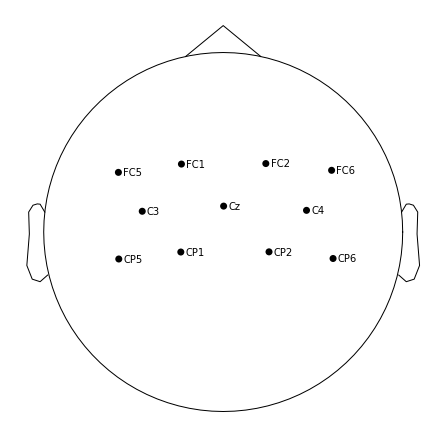

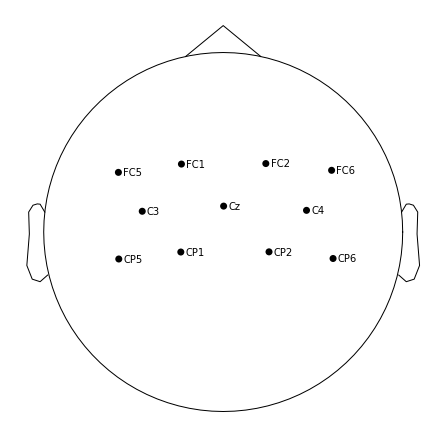

In [75]:
ds.datasets[0].windows.plot_sensors(show_names=True)

In [14]:
x = ds.datasets[0].windows.get_data()
x.shape

(19, 11, 256)

In [9]:
xdup = np.concatenate((x[:, :, ::-1], x, x[:, :, ::-1]), axis=2)
xdup.shape

(19, 11, 768)

In [18]:
fbx = list()
for fmin, fmax in [(i, i + 4) for i in range(8, 28, 2)]:
    fbx.append(mne.filter.filter_data(x, sfreq=128.0, l_freq=fmin, h_freq=fmax, verbose=False))

In [10]:
fbxdup = list()
for fmin, fmax in [(8, 12), (12, 16), (16, 20), (20, 24), (24, 30)]:
    fbxdup.append(mne.filter.filter_data(xdup, sfreq=128.0, l_freq=fmin, h_freq=fmax, verbose=False))

In [13]:
[(i, i + 4) for i in range(8, 28, 2)]

[(8, 12),
 (10, 14),
 (12, 16),
 (14, 18),
 (16, 20),
 (18, 22),
 (20, 24),
 (22, 26),
 (24, 28),
 (26, 30)]

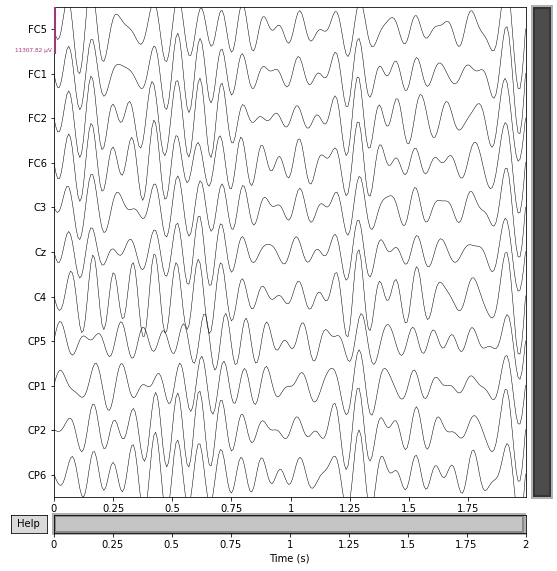

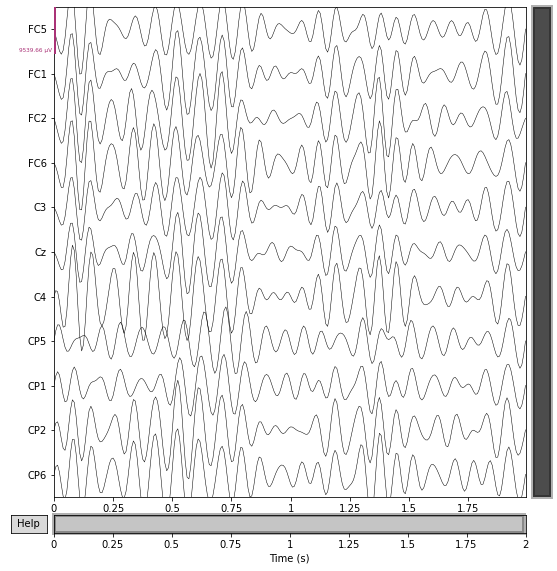

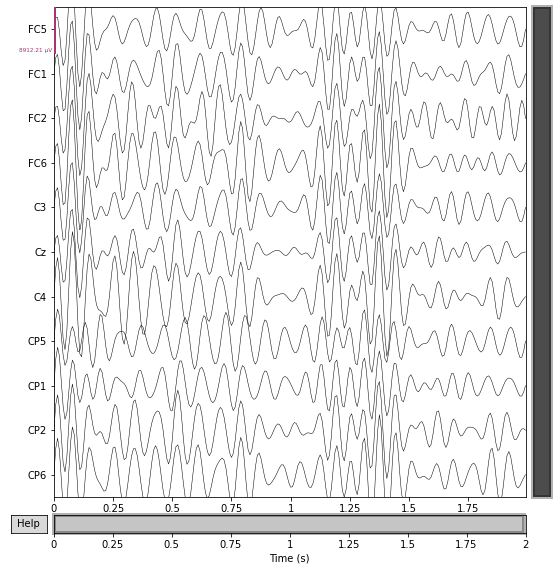

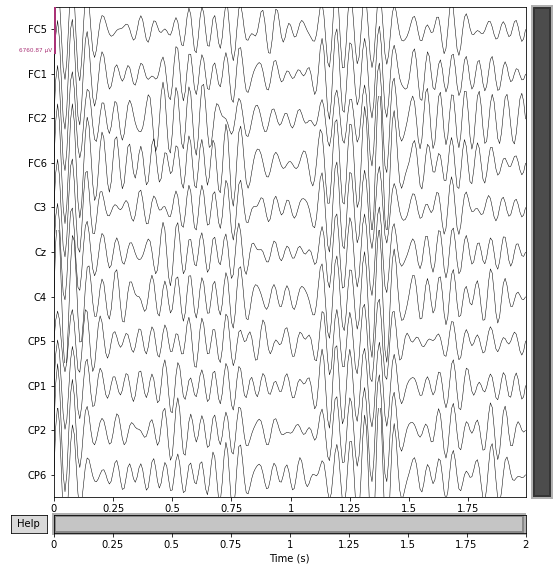

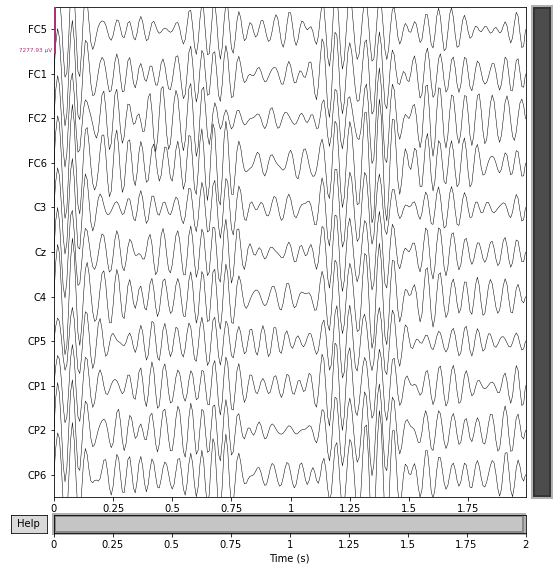

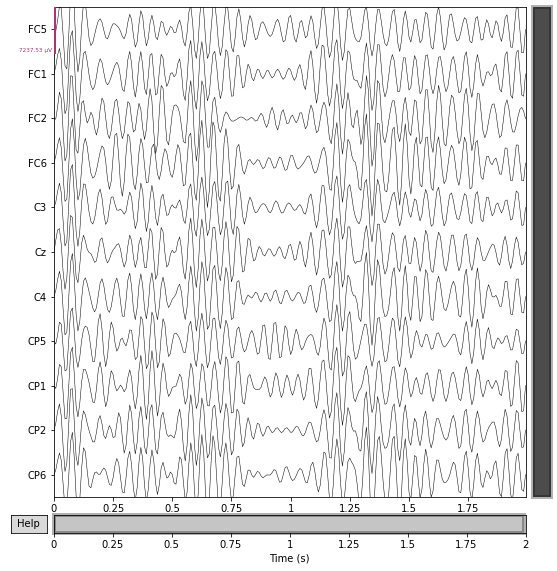

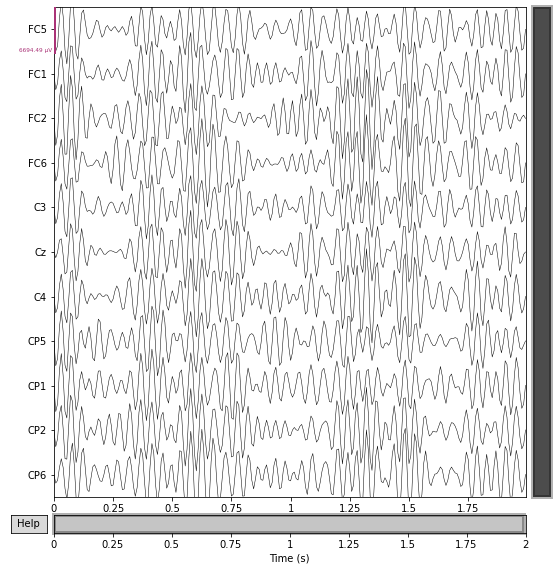

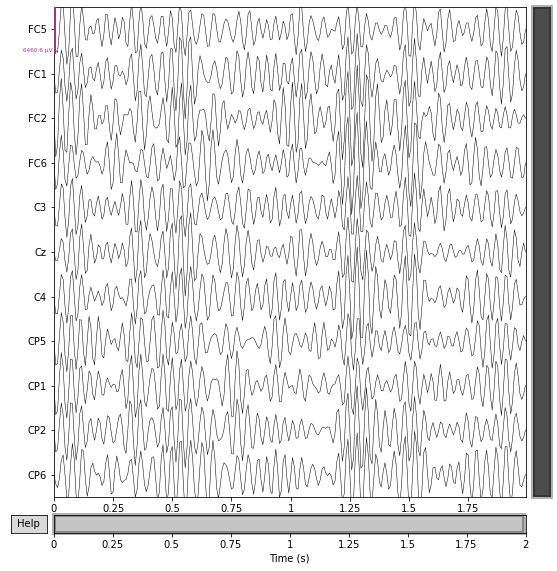

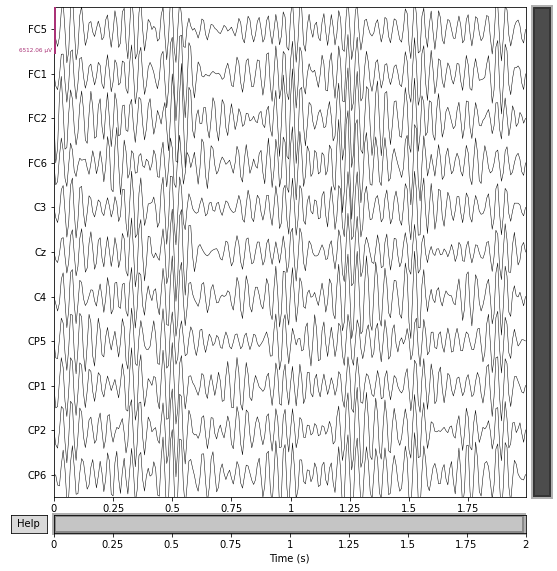

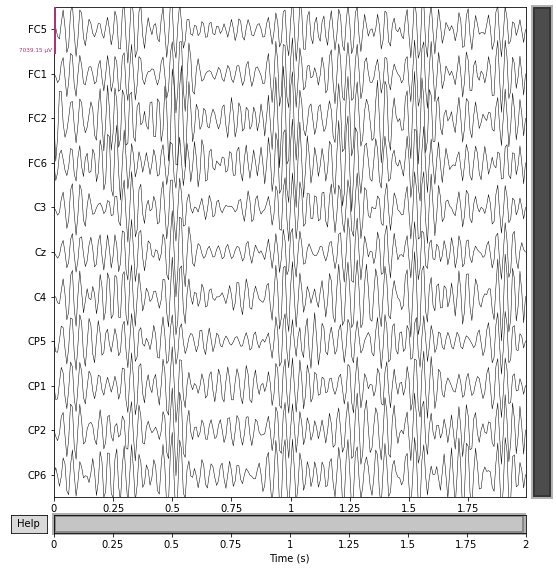

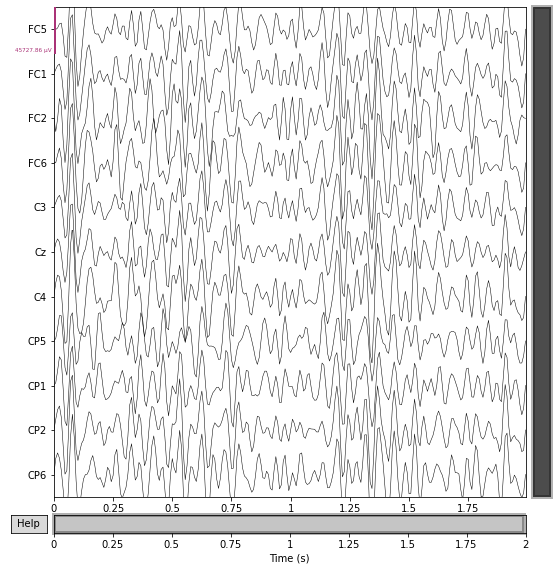

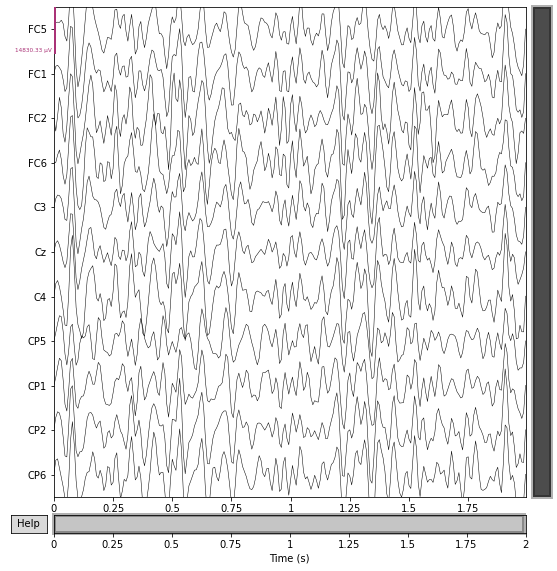

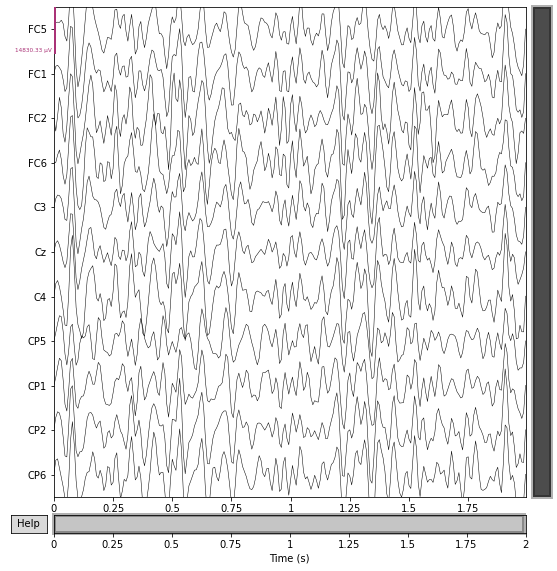

In [27]:
info = ds.datasets[0].windows.info

x0 = 0
for xi in fbx:
    x0 += xi[0]
    ri = mne.io.RawArray(xi[0], info=info)
    ri.plot(scalings="auto")
    # ri.plot_psd()
    
r0 = mne.io.RawArray(x0, info=info)
r0.plot(scalings="auto")

mne.io.RawArray(x[0], info=info).filter(8, 30).plot(scalings="auto")

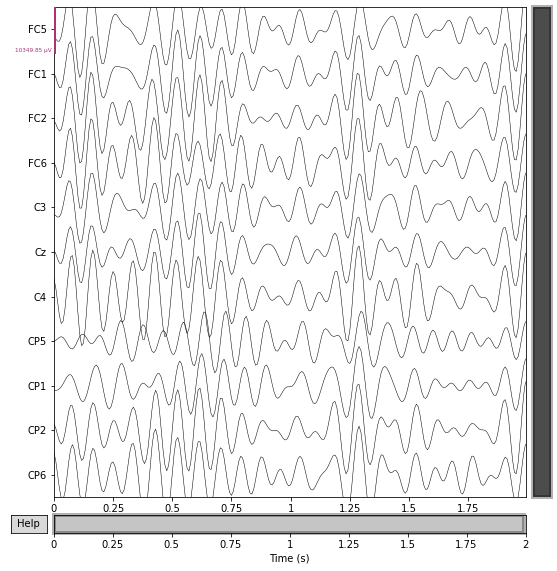

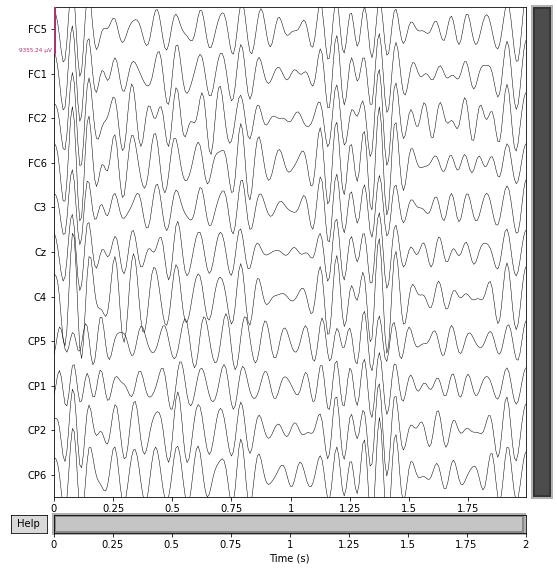

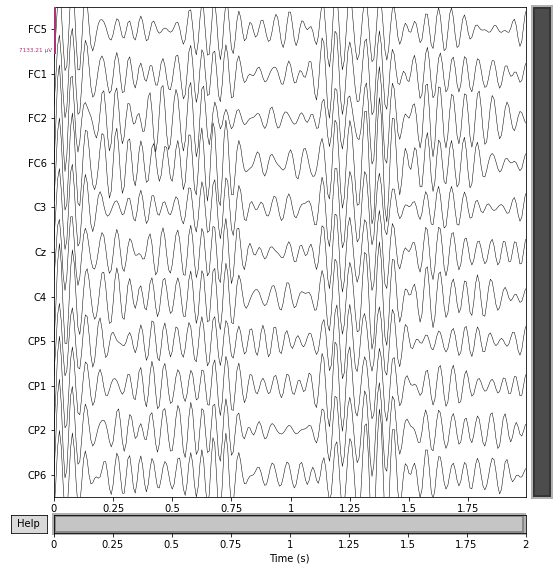

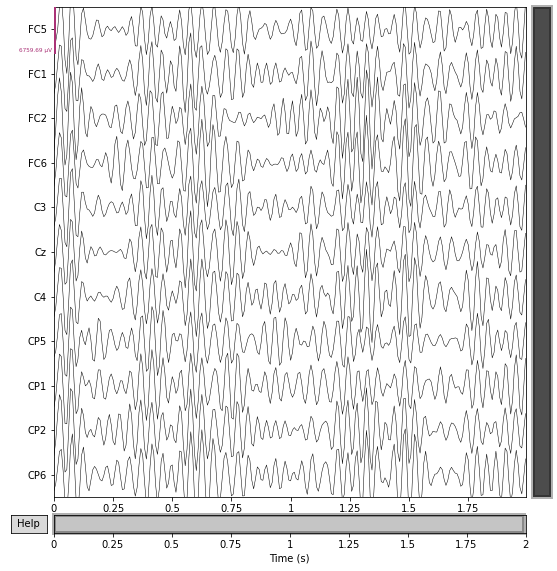

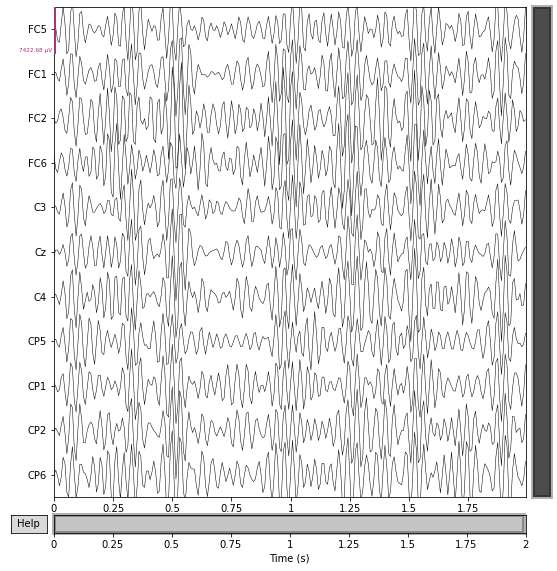

In [11]:
for xi in fbxdup:
    mne.io.RawArray(xi[0, :, 256:512], info=info).plot(scalings="auto")

In [4]:
target_subject = "K300"

# aligned_ds = deepcopy(ds)
# euclidean_alignment(aligned_ds, target_subject=None, labeled_trials=None)
# label_alignment(aligned_ds, target_subject=target_subject, labeled_trials=None)

In [20]:
from sklearn.preprocessing import LabelEncoder

In [21]:
x = list()
y = list()
s = list()
for i, r in ds_info.iterrows():
    x.append(aligned_ds.datasets[i].windows.get_data())
    y.extend(aligned_ds.datasets[i].y)
    s.extend([r["split"]] * len(aligned_ds.datasets[i].y))
    
x = np.concatenate(x, axis=0)
y = np.array(y, dtype=int)

le = LabelEncoder()
s = le.fit_transform(s)
print(le.classes_)

x.shape, y.shape

['train' 'valid']


((10090, 32, 256), (10090,))

In [22]:
c = np.stack([np.cov(xi, rowvar=True) for xi in x])
c.shape

(10090, 32, 32)

<AxesSubplot:>

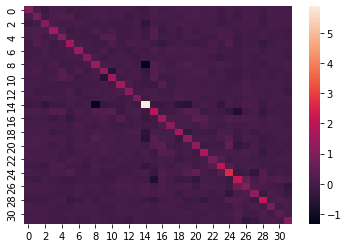

In [23]:
sb.heatmap(c[np.where(y == 0)[0]].mean(axis=0))

<AxesSubplot:>

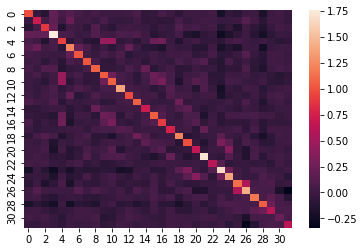

In [24]:
sb.heatmap(c[np.where(y == 1)[0]].mean(axis=0))

In [25]:
from sklearn.manifold import TSNE
from pyriemann.tangentspace import TangentSpace

In [26]:
ts = TangentSpace(metric="riemann")

feat = ts.fit_transform(c)

In [27]:
%%time
feat2d = TSNE(n_components=2).fit_transform(feat)

/home/txdat/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/txdat/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


CPU times: user 1min 31s, sys: 649 ms, total: 1min 31s
Wall time: 24 s


In [28]:
ds.datasets[0].windows.event_id

{'nâng chân phải': 0,
 'nâng chân trái': 1,
 'nâng tay phải': 2,
 'nâng tay trái': 3}

In [29]:
colors = 'bgrcmyk'
labels = {v: k for k, v in ds.datasets[0].windows.event_id.items()}

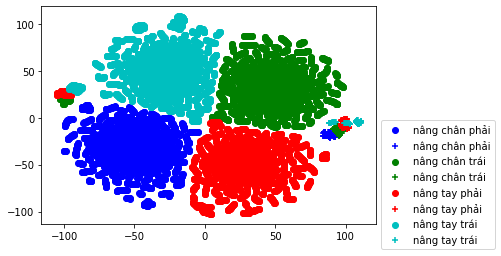

In [18]:
lbl = []
for i, yi in enumerate(np.unique(y)):
    idx = np.where((y == yi) & (s == 0))[0]
    plt.scatter(feat2d[idx, 0], feat2d[idx, 1], c=colors[i], marker='o', label=labels[yi])
    
    idx = np.where((y == yi) & (s == 1))[0]
    plt.scatter(feat2d[idx, 0], feat2d[idx, 1], c=colors[i], marker='+', label=labels[yi])
    
plt.legend(bbox_to_anchor=(1, 0.5))

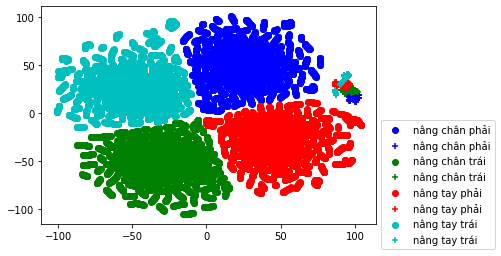

In [30]:
lbl = []
for i, yi in enumerate(np.unique(y)):
    idx = np.where((y == yi) & (s == 0))[0]
    plt.scatter(feat2d[idx, 0], feat2d[idx, 1], c=colors[i], marker='o', label=labels[yi])
    
    idx = np.where((y == yi) & (s == 1))[0]
    plt.scatter(feat2d[idx, 0], feat2d[idx, 1], c=colors[i], marker='+', label=labels[yi])
    
plt.legend(bbox_to_anchor=(1, 0.5))

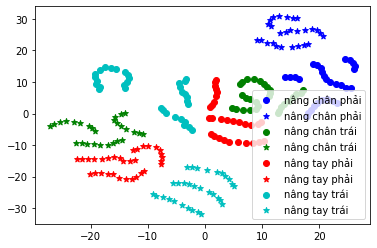

In [117]:
lbl = []
for i, yi in enumerate(np.unique(y)):
    idx = np.where((y == yi) & (s == 0))[0]
    plt.scatter(feat2d[idx, 0], feat2d[idx, 1], c=colors[i], marker='o', label=labels[yi])
    
    idx = np.where((y == yi) & (s == 1))[0]
    plt.scatter(feat2d[idx, 0], feat2d[idx, 1], c=colors[i], marker='*', label=labels[yi])
    
plt.legend()

In [5]:
repochs = mne.concatenate_epochs([ds.datasets[i].windows for i in ds_info[(ds_info["subject"] == "K300") & (ds_info["label"] == "nâng tay phải")].index])
lepochs = mne.concatenate_epochs([ds.datasets[i].windows for i in ds_info[(ds_info["subject"] == "K300") & (ds_info["label"] == "nâng tay trái")].index])

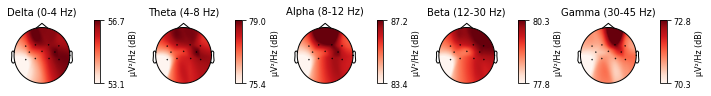

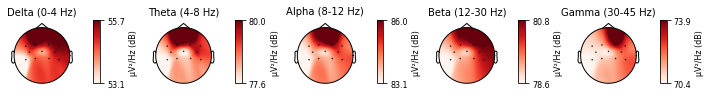

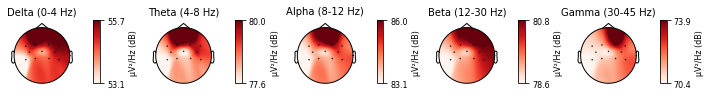

In [6]:
repochs.plot_psd_topomap()
lepochs.plot_psd_topomap()

In [7]:
freq_range = np.arange(8, 32)

rpower = mne.time_frequency.tfr_multitaper(repochs, freqs=freq_range, n_cycles=freq_range / 2.0, use_fft=True,
                                           return_itc=False, average=True, decim=2)
lpower = mne.time_frequency.tfr_multitaper(lepochs, freqs=freq_range, n_cycles=freq_range / 2.0, use_fft=True,
                                           return_itc=False, average=True, decim=2)

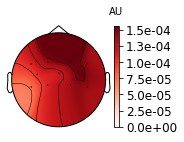

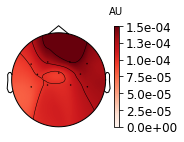

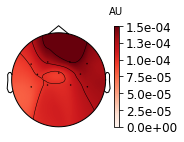

In [9]:
rpower.plot_topomap()
lpower.plot_topomap()

In [16]:
epochs1 = mne.concatenate_epochs([ds.datasets[i].windows for i in ds_info[(ds_info["subject"] == "K314") & (ds_info["label"] == "nâng tay phải")].index])
epochs2 = mne.concatenate_epochs([ds.datasets[i].windows for i in ds_info[(ds_info["subject"] == "K324") & (ds_info["label"] == "nâng tay phải")].index])

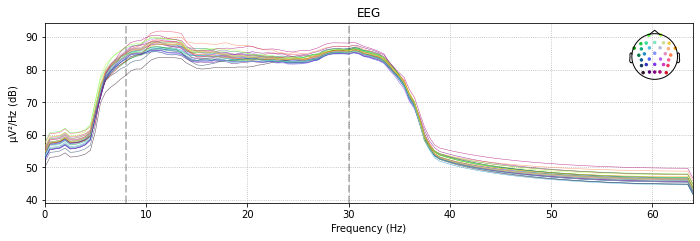

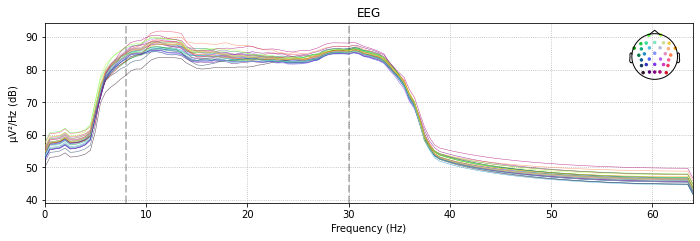

In [17]:
epochs1.plot_psd(average=False)

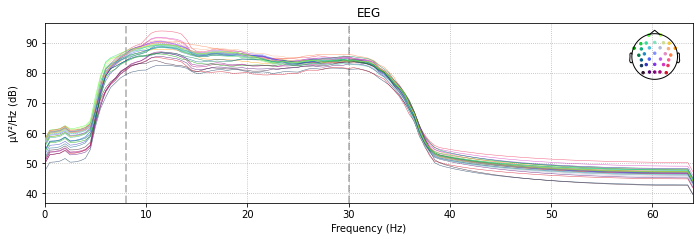

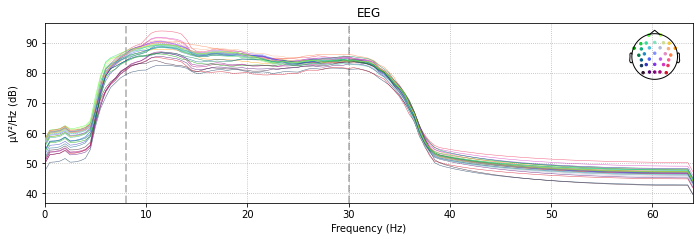

In [18]:
epochs2.plot_psd()

In [20]:
freq_range = np.arange(8, 30)

power1 = mne.time_frequency.tfr_multitaper(epochs1, freqs=freq_range, n_cycles=freq_range / 2.0, use_fft=True,
                                           return_itc=False, average=True, decim=2)
power2 = mne.time_frequency.tfr_multitaper(epochs2, freqs=freq_range, n_cycles=freq_range / 2.0, use_fft=True,
                                           return_itc=False, average=True, decim=2)

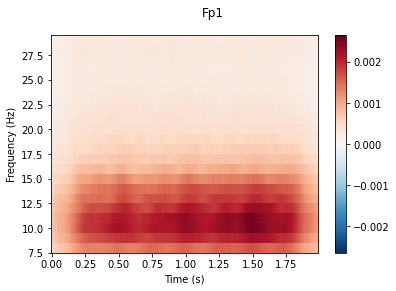

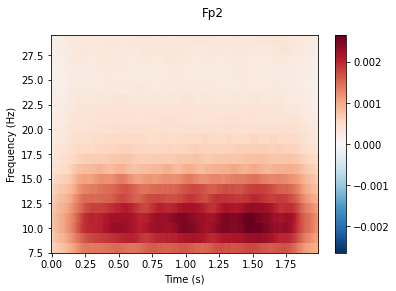

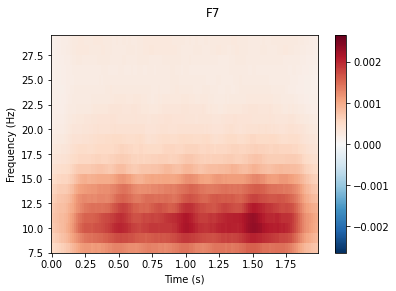

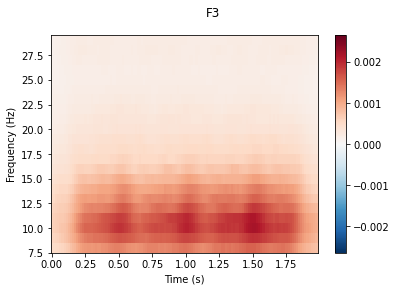

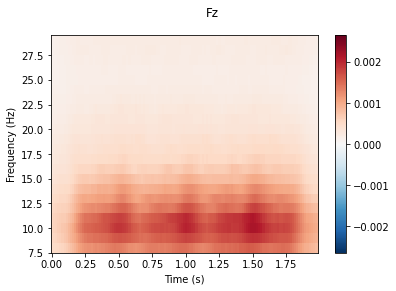

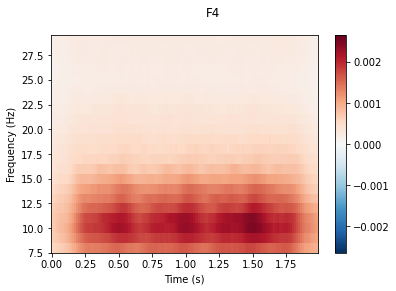

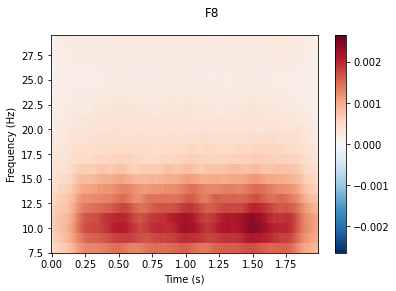

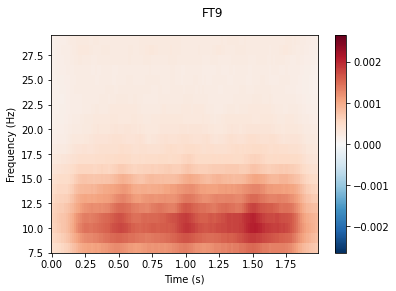

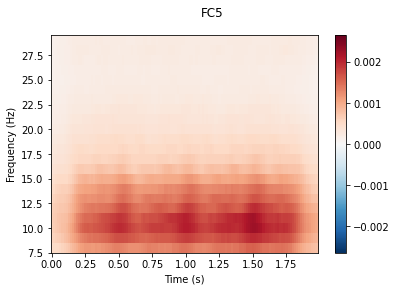

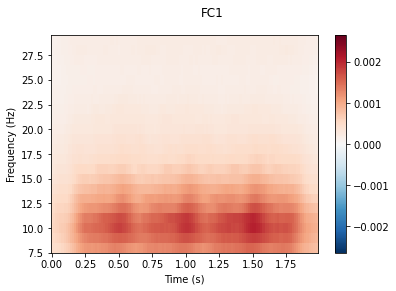

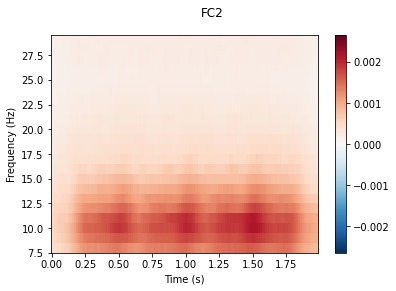

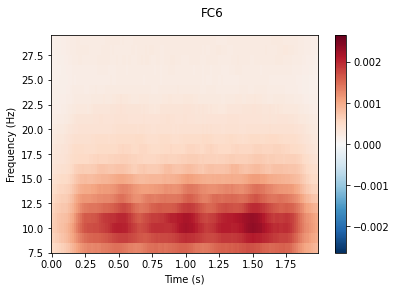

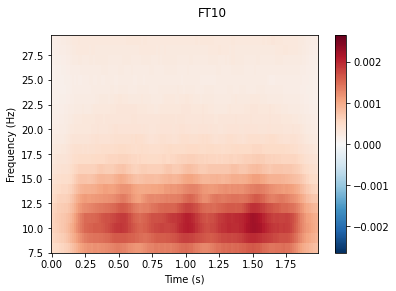

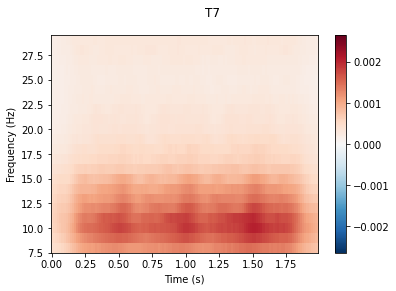

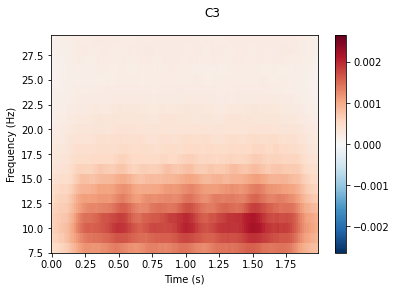

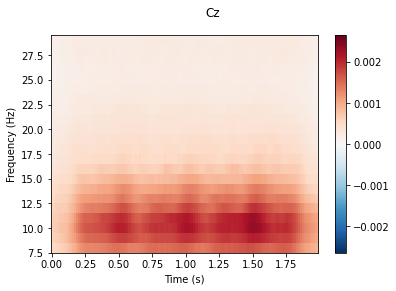

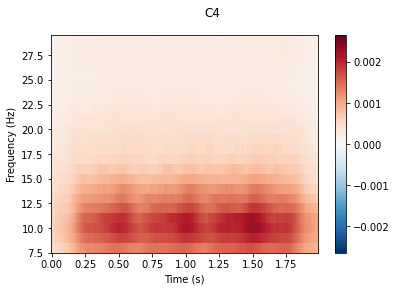

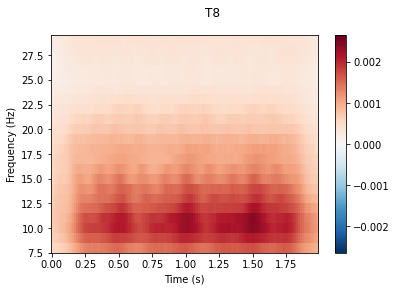

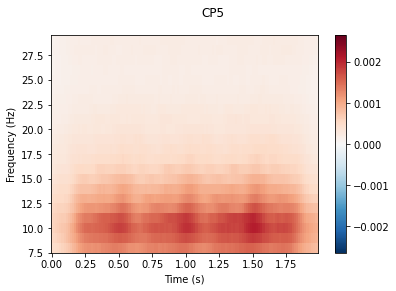

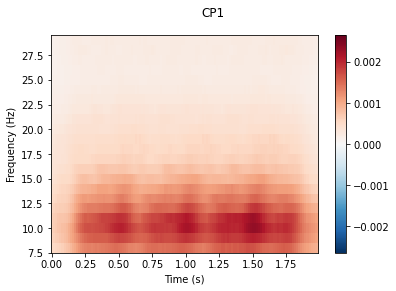

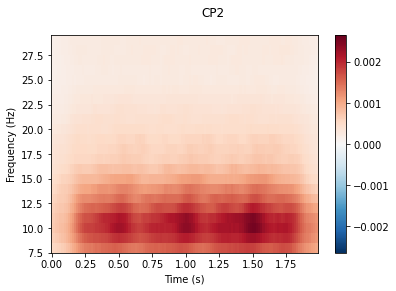

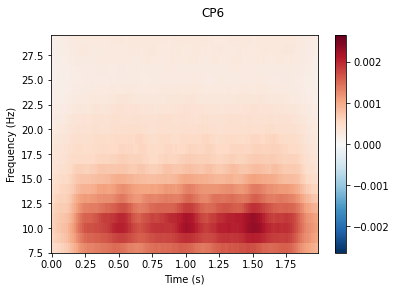

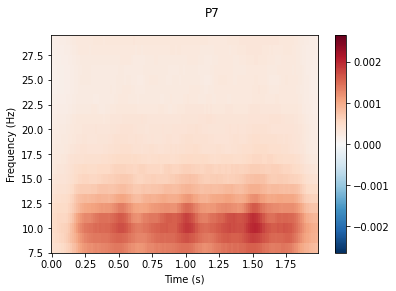

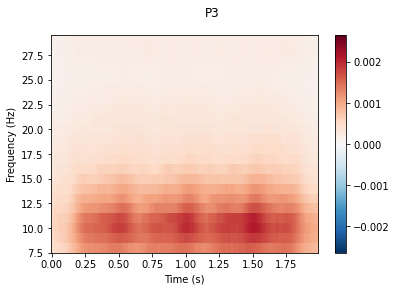

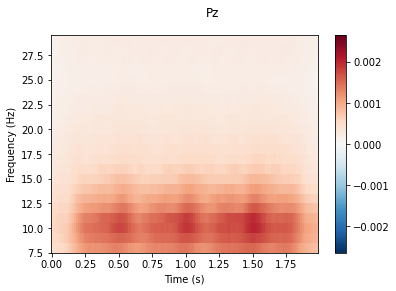

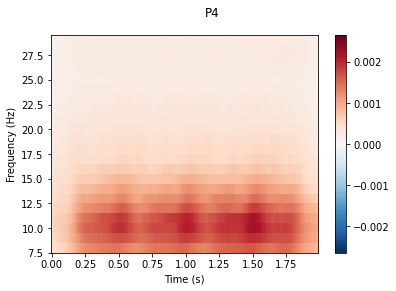

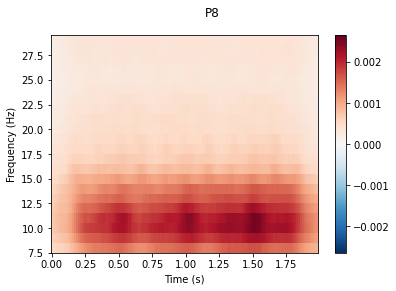

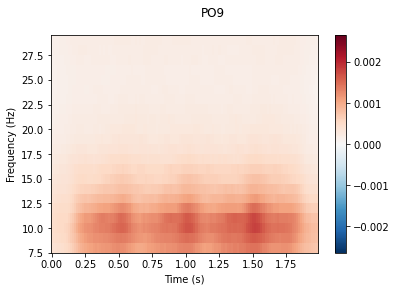

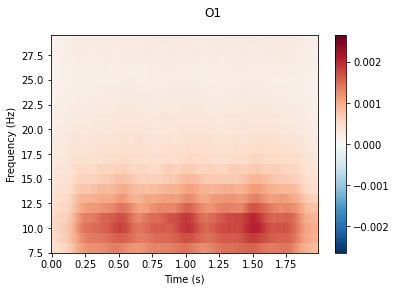

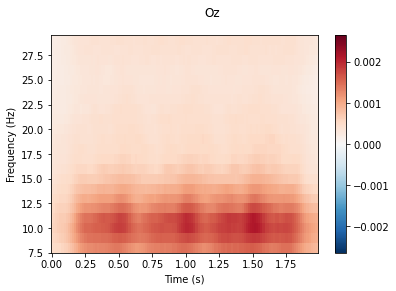

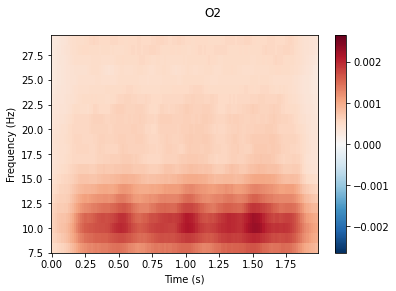

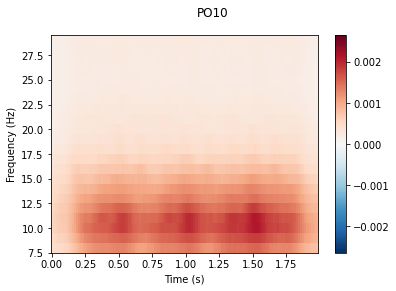

[<Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2

In [13]:
power1.plot(title="auto", mode="logratio")

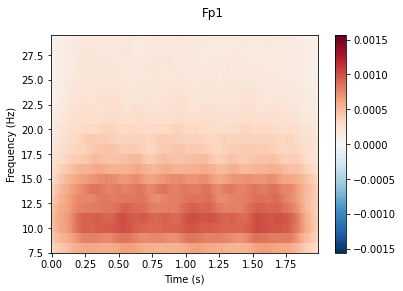

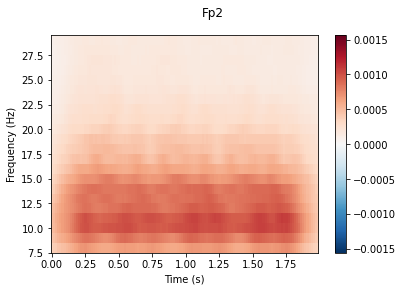

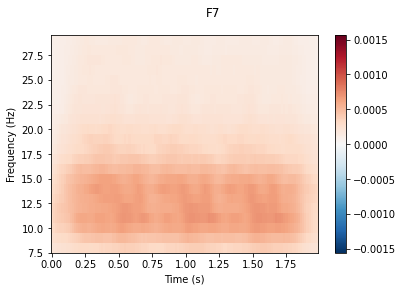

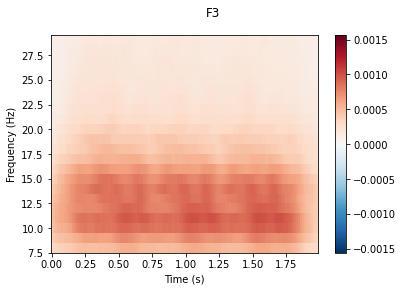

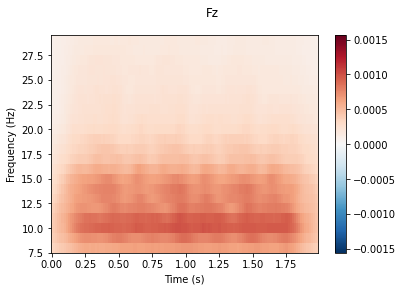

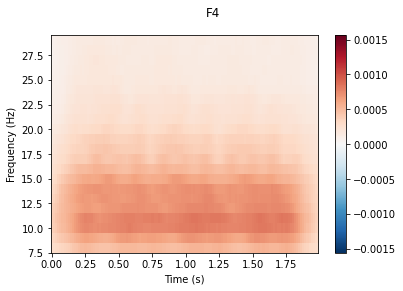

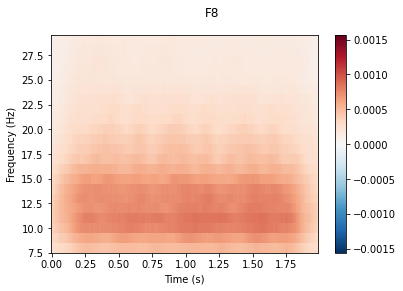

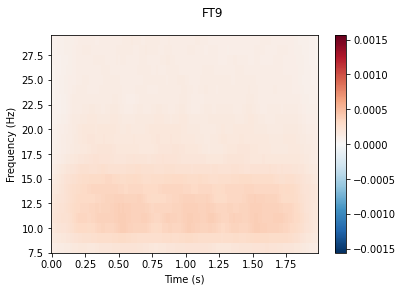

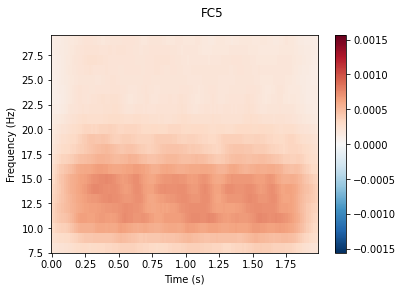

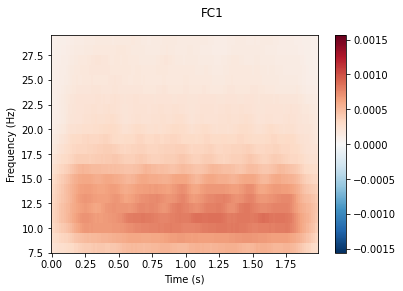

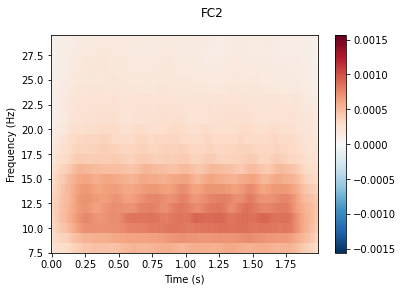

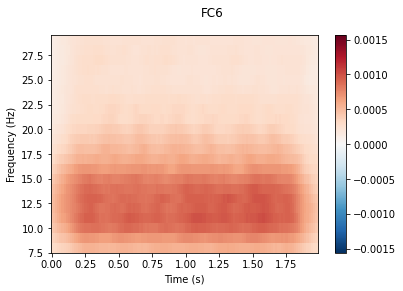

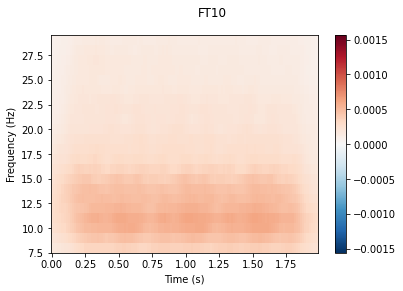

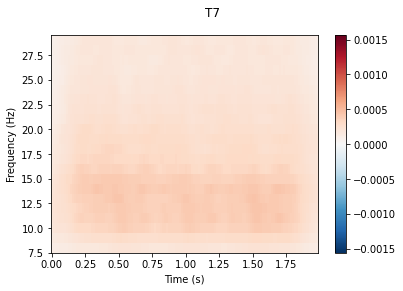

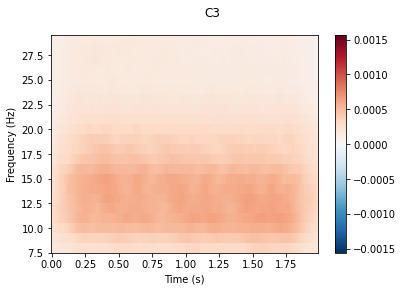

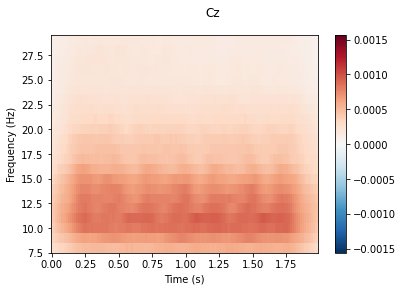

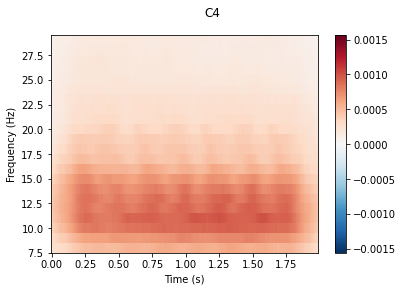

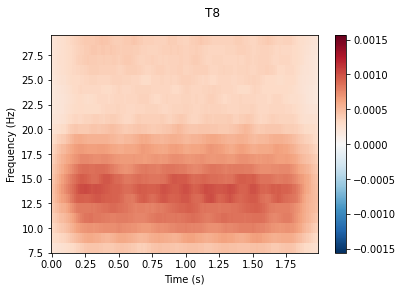

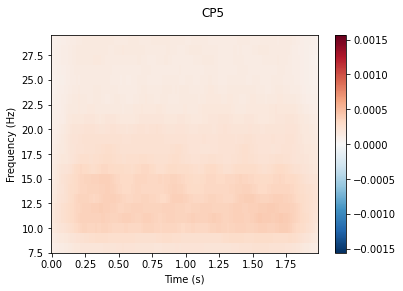

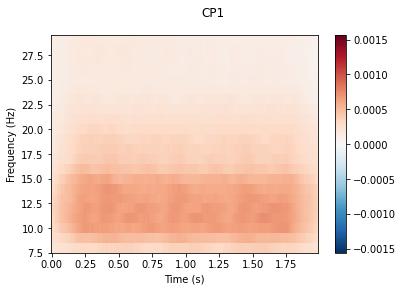

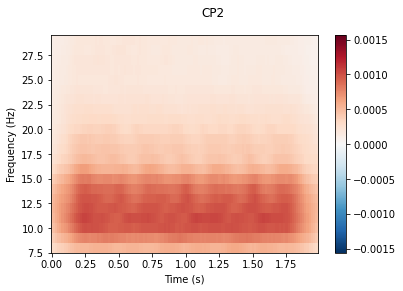

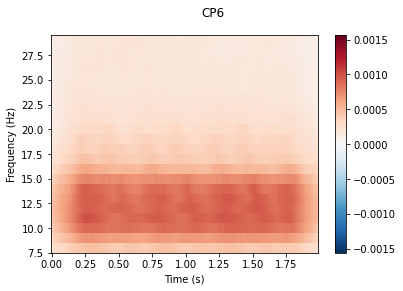

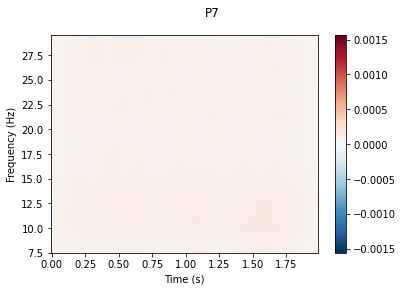

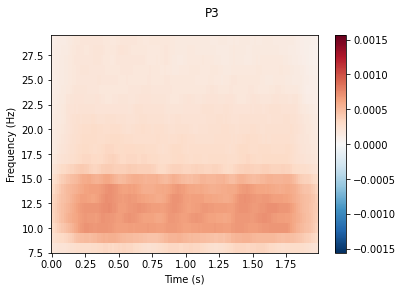

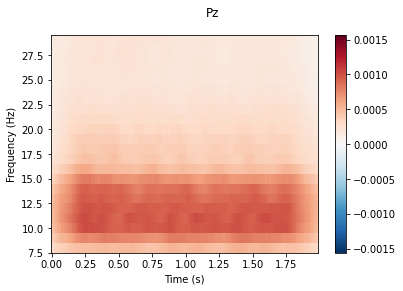

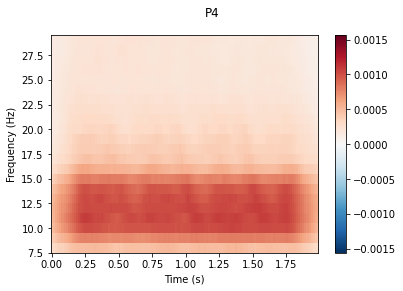

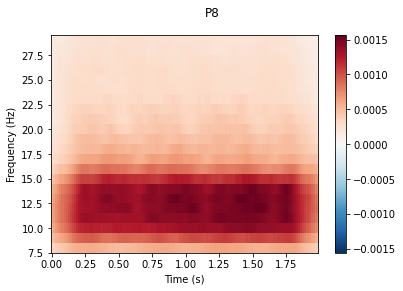

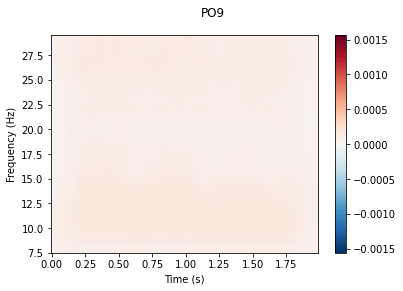

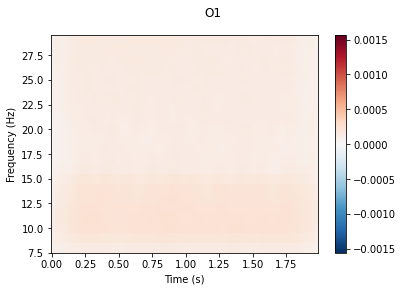

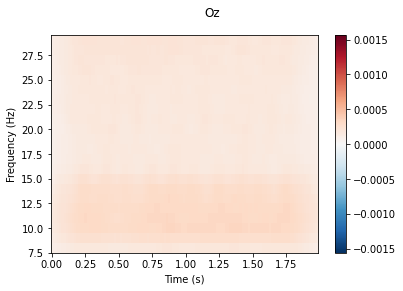

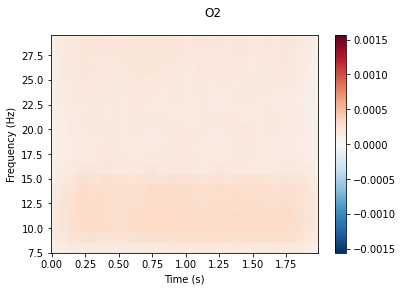

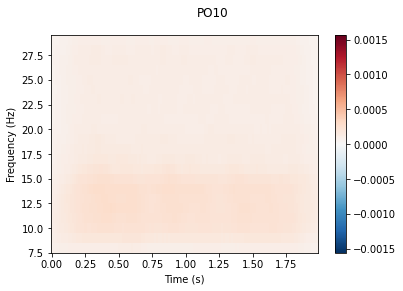

[<Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2

In [14]:
power2.plot(title="auto", mode="logratio")

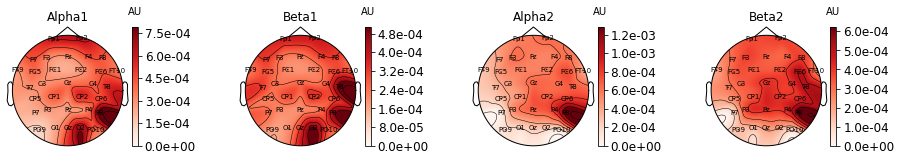

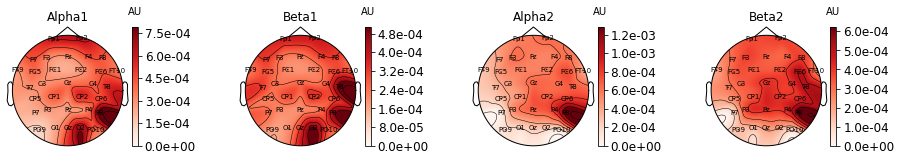

In [21]:
fig, axis = plt.subplots(1, 4, figsize=(16, 2))

# power.plot_topomap(ch_type='eeg', fmin=4, fmax=8,
#                    mode='logratio', axes=axis[0],
#                    title='Theta', show_names=True, show=False)
power1.plot_topomap(ch_type='eeg', fmin=8, fmax=12,
                   mode='logratio', axes=axis[0],
                   title='Alpha1', show_names=True, show=False)
power1.plot_topomap(ch_type='eeg', fmin=12, fmax=30,
                   mode='logratio', axes=axis[1],
                   title='Beta1', show_names=True, show=False)
# power.plot_topomap(ch_type='eeg', fmin=30, fmax=38,
#                    mode='logratio', axes=axis[3],
#                    title='Gamma', show_names=True, show=False)
power2.plot_topomap(ch_type='eeg', fmin=8, fmax=12,
                   mode='logratio', axes=axis[2],
                   title='Alpha2', show_names=True, show=False)
power2.plot_topomap(ch_type='eeg', fmin=12, fmax=30,
                   mode='logratio', axes=axis[3],
                   title='Beta2', show_names=True, show=False)

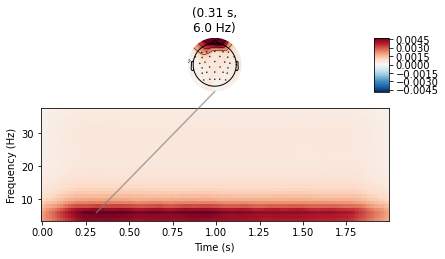

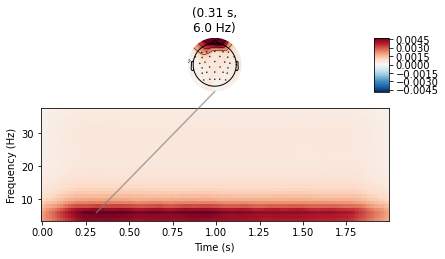

In [19]:
power.plot_joint()

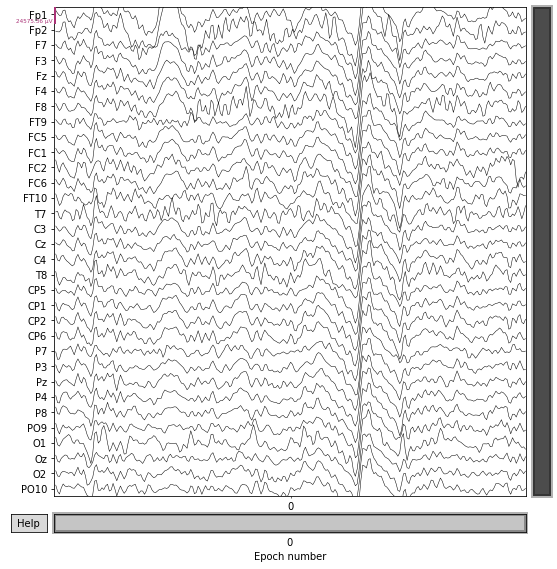

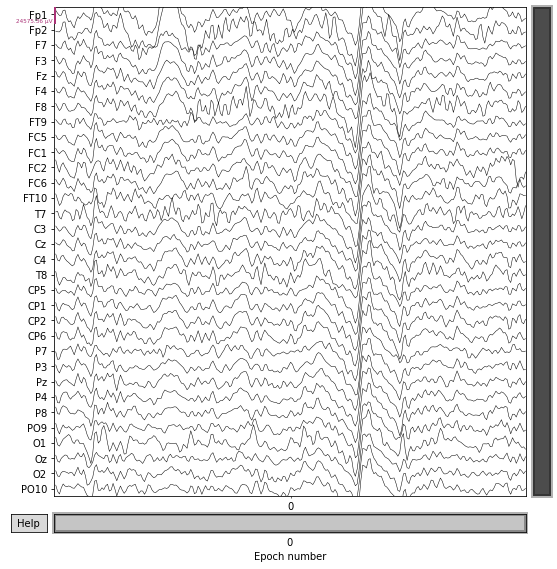

In [43]:
epochs[0].plot(n_channels=32, scalings="auto")

In [34]:
epochs0 = epochs.copy()

In [35]:
epochs0.apply_function(np_standardize, channel_wise=False, tdim=2, robust=False)

<Epochs |  372 events (all good), 0 - 1.99219 sec, baseline off, ~23.3 MB, data loaded, with metadata,
 'gật đầu': 0
 'lắc đầu': 0
 'nâng chân phải': 0
 'nâng chân trái': 0
 'nâng tay phải': 0
 'nâng tay trái': 0
 'rest': 372>

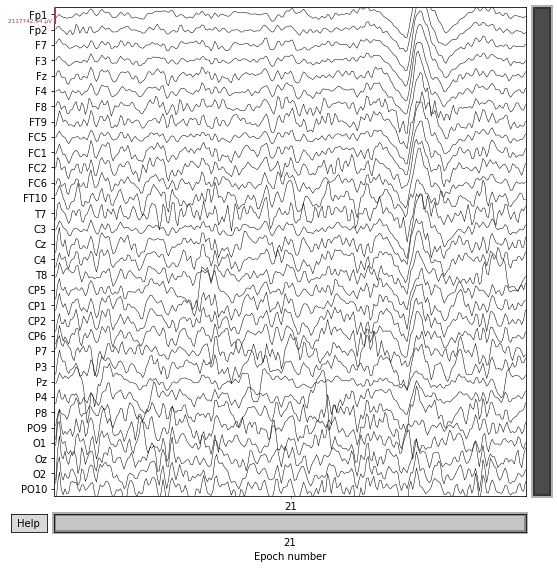

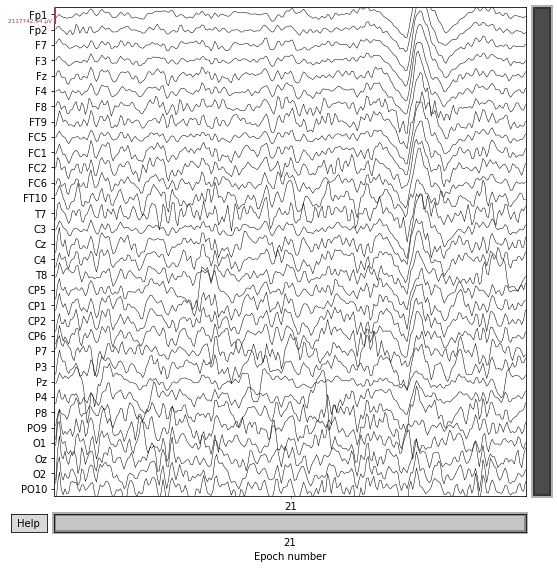

In [36]:
epochs0[21].plot(n_channels=32, scalings="auto")

In [59]:
epochs0 = epochs.copy().apply_function(lambda x: x * 1e6, channel_wise=False)

x = epochs0.get_data()
x.shape

(372, 32, 256)

In [60]:
cov = np.stack([np.cov(xi, rowvar=True) for xi in x])

<AxesSubplot:>

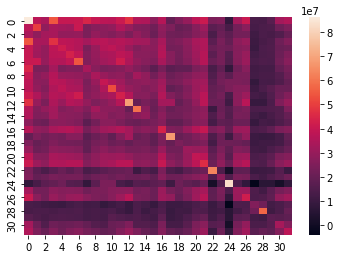

In [64]:
sb.heatmap(cov[5])

<AxesSubplot:>

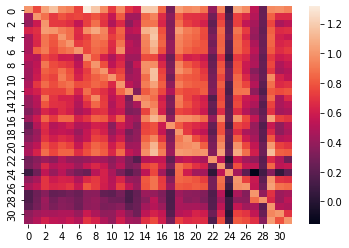

In [63]:
sb.heatmap(cov[5] / np.diag(cov[5]))

In [22]:
rng = np.random.RandomState(seed=42)

/home/txdat/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

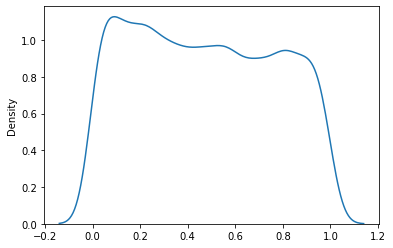

In [94]:
sb.distplot(rng.beta(0.9, 1.0, 10000), hist=False)
# sb.distplot(rng.beta(0.4, 0.4, 10000), hist=False)